<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/Frecuencia%20inscripciones%5CSuavizadoSeriesTiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis de la frecuencia de inscripciones



## Carga de información

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
# carga de archivo
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Frecuencia%20inscripciones/data/conversionesPE.csv", index_col=0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
raw_csv_data.head()

,FechaConsultora,FuenteIngreso,cantidad,Pais
1,26/08/19,MovilGZ,33,Perú
2,10/03/19,CALL CENTER,1,Perú
3,04/11/19,MovilGZ,30,Perú
4,13/02/19,UB,31,Perú
5,04/11/19,CALL CENTER,4,Perú


In [5]:
raw_csv_data.describe()

,cantidad
count,3846.000000
mean,88.921477
std,162.569807
min,1.000000
25%,3.000000
50%,18.000000
75%,54.750000
max,922.000000


## Transformación y formateo de datos
 

In [6]:
# Transformacion de datos para analisis temporal
df = raw_csv_data.copy()
df=df[df.FuenteIngreso == "UB"]
df['Fecha'] = pd.to_datetime(raw_csv_data.FechaConsultora, dayfirst = True)
df['inscripciones'] = df.cantidad
del df['FuenteIngreso']
del df['Pais']
del df['FechaConsultora']
del df['cantidad']
# se agrupa y se reindexa el dataframe
df = df.groupby(['Fecha']).sum().reset_index()
df.set_index('Fecha', inplace=True, verify_integrity=True)
# establecer frecuencia
#df.sort_index().asfreq(freq='d')
df.index = pd.DatetimeIndex(df.index).to_period('d')
# cambiar frecuencia a meses
#df.index.freq = 'MS'
df.head()
dfAR = df.copy()


## Gráfico de la serie temporal

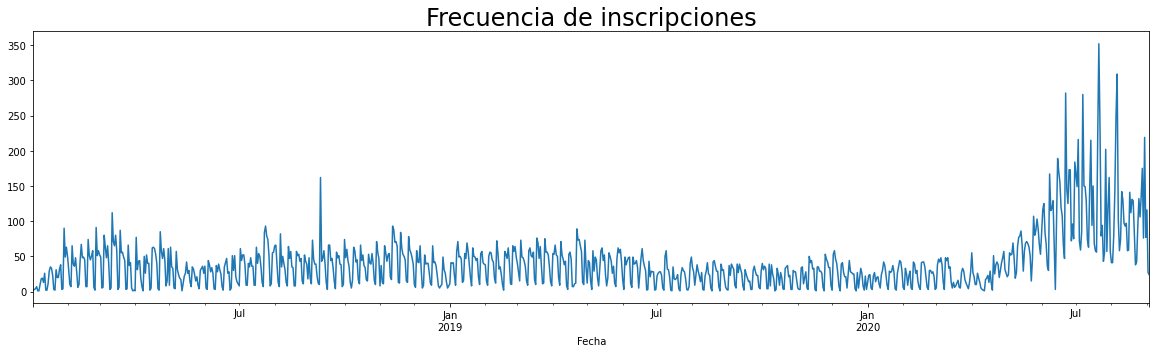

In [6]:
df.inscripciones.plot(figsize = (20,5))
plt.title("Frecuencia de inscripciones", size= 24)
plt.show()
#df.head()

## Estacionariedad

In [ ]:
sts.adfuller(df.inscripciones)

(-0.8994044296141788,
 0.7881684842751513,
 21,
 946,
 {'1%': -3.437281430175827,
  '10%': -2.5683993544869015,
  '5%': -2.8646000638781532},
 8562.578395792347)

### Interpretación de resultado:

**Contraste de hipotesis**

-0.8994044296141788 representa el estadistico que se va a comparar con el valor crítico
 {'1%': -3.437281430175827,
  '10%': -2.5683993544869015,
  '5%': -2.8646000638781532}
Representan los niveles de significacion para cada nivel de confianza.

Como el valor del estadistico es meyor a todos los niveles, no se rechaza la hipotesis nula, **por lo tanto la serie no es estacionaria**

**P valor**

0.7881684842751513 representa el P valor
los niveles de significacion para comparar serían 
0.01
0.10
0.05

Como el P valor es mas alto, no se rechaza la hipotesis nula y se considera que la serie es no estacionaria

## Estacionalidad

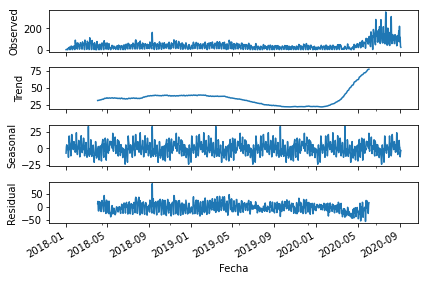

In [ ]:
s_dec_additive = seasonal_decompose(df.inscripciones, "additive", freq=185)
s_dec_additive.plot()
plt.show()

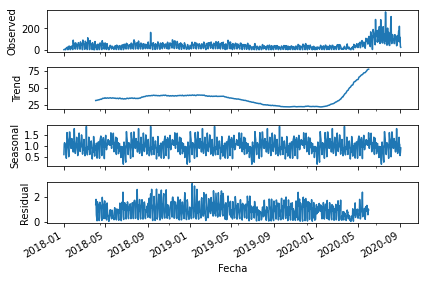

In [ ]:
s_dec_additive = seasonal_decompose(df.inscripciones, "multiplicative", freq=185)
s_dec_additive.plot()
plt.show()

## Filtro Hodrick Prescott

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter
gdp_cycle, gdp_trend = hpfilter(df['inscripciones'], lamb=129600)
df['tendencia mensual'] = gdp_trend
gdp_cycle, gdp_trend = hpfilter(df['inscripciones'], lamb=3888000)
df['tendencia diaria'] = gdp_trend
df.head()

,inscripciones,tendencia mensual,tendencia diaria
Fecha,,,
2018-01-02,2,9.620571,25.123440
2018-01-03,3,10.391450,25.280865
2018-01-04,4,11.162271,25.438284
2018-01-05,7,11.932917,25.595685
2018-01-06,1,12.703217,25.753052


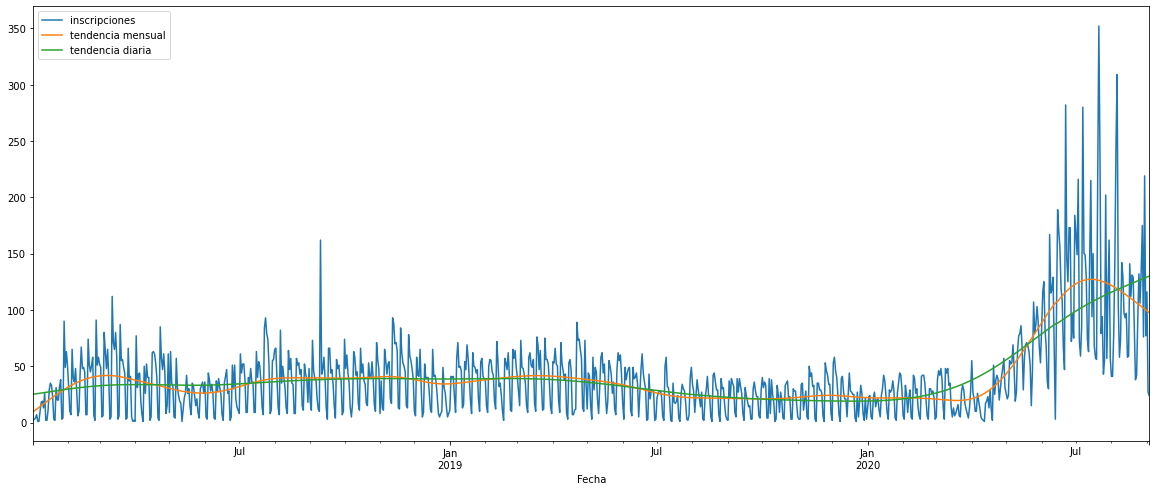

In [ ]:
df[['inscripciones','tendencia mensual', 'tendencia diaria']].plot(figsize=(20,8))

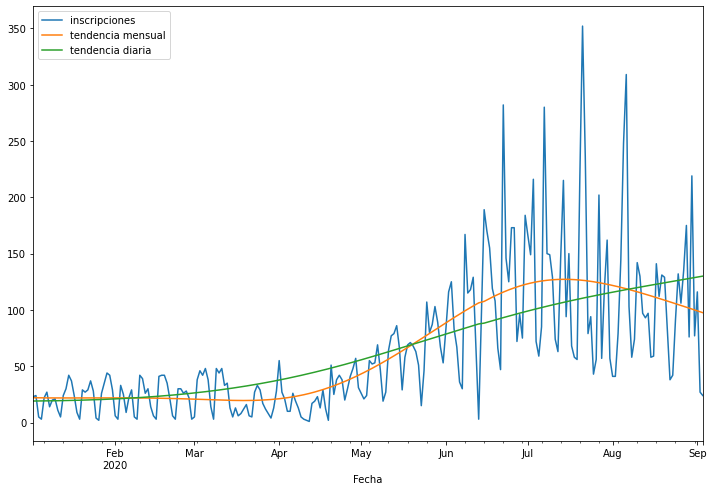

In [ ]:
df[['inscripciones','tendencia mensual', 'tendencia diaria']]['2020-01-01':].plot(figsize=(12,8))

## Promedio móvil 

### Promedio movil simple

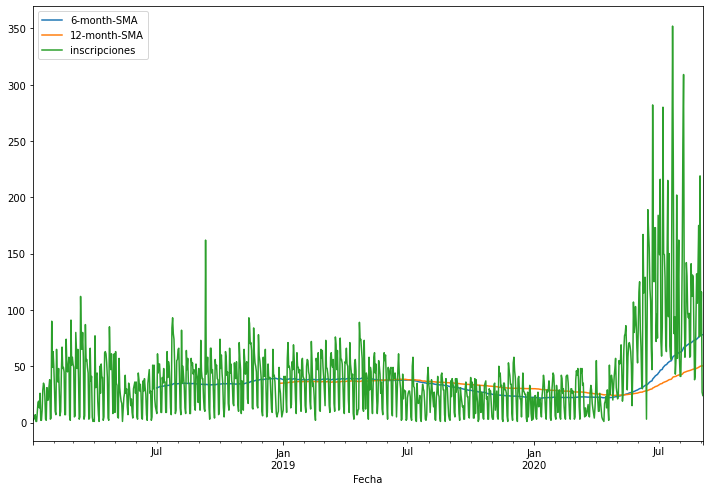

In [ ]:
df['6-month-SMA'] = df['inscripciones'].rolling(window=180).mean()
df['12-month-SMA'] = df['inscripciones'].rolling(window=360).mean()
df[['6-month-SMA','12-month-SMA', 'inscripciones']].plot(figsize=(12,8));

EWMA

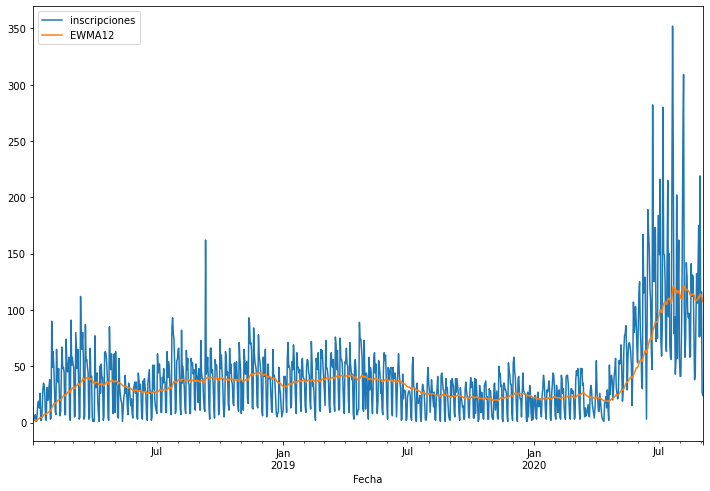

In [ ]:
df['EWMA12'] = df['inscripciones'].ewm(span=60,adjust=False).mean()
df[['inscripciones','EWMA12']].plot(figsize=(12,8));

### Suavizado exponencial simple

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['SES12']=SimpleExpSmoothing(df['inscripciones']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)


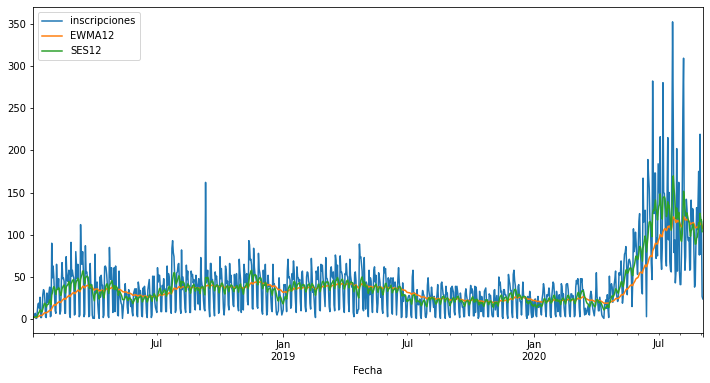

In [ ]:
df[['inscripciones','EWMA12','SES12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### Suavizado exponencial doble

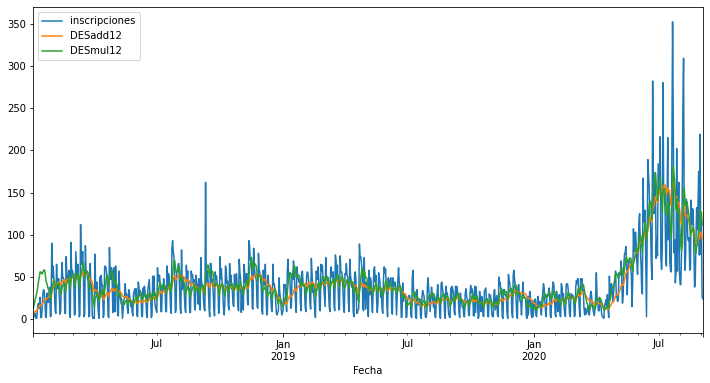

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
## aditivo
df['DESadd12'] = ExponentialSmoothing(df['inscripciones'], trend = 'add').fit().fittedvalues.shift(-1)
## multiplicativo
df['DESmul12'] = ExponentialSmoothing(df['inscripciones'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

df[['inscripciones','DESadd12','DESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### Suavizado exponencial triple

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


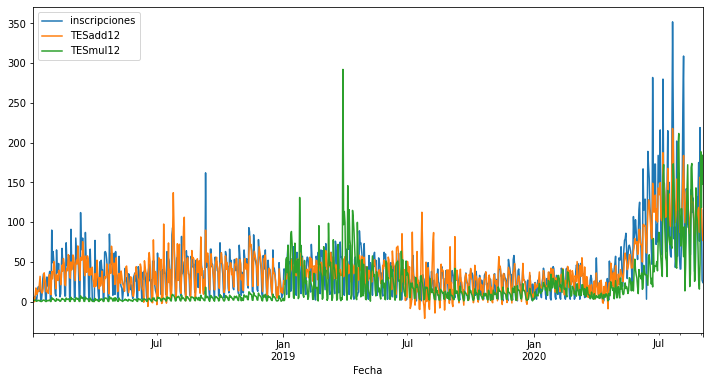

In [ ]:
# aditivo
df['TESadd12'] = ExponentialSmoothing(df['inscripciones'],trend='add',seasonal='add',seasonal_periods=360).fit().fittedvalues

# multiplicativo
df['TESmul12'] = ExponentialSmoothing(df['inscripciones'],trend='mul',seasonal='mul',seasonal_periods=360).fit().fittedvalues

df[['inscripciones','TESadd12','TESmul12']].plot(figsize=(12,6));

### Predicciones con los modelos de suavizado


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


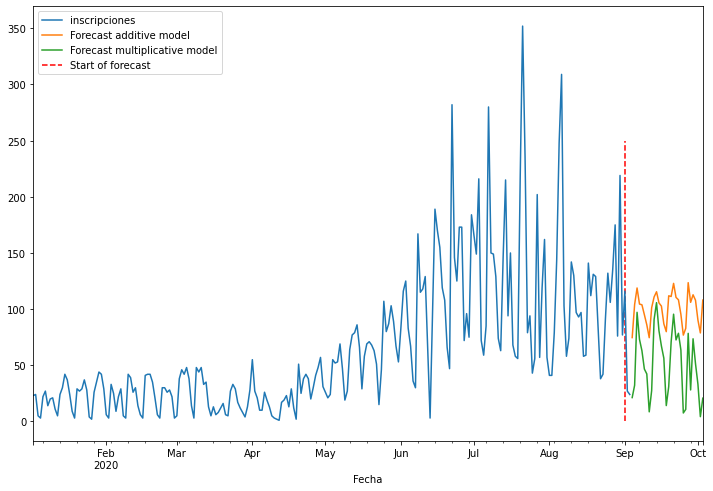

In [ ]:
model_add = ExponentialSmoothing(df['inscripciones'],trend='add',seasonal='add',seasonal_periods=360).fit()
model_mul = ExponentialSmoothing(df['inscripciones'],trend='mul',seasonal='mul',seasonal_periods=360).fit()

forecast_add = model_add.forecast(30)
forecast_mul= model_mul.forecast(30)

df['inscripciones']['2020-01-01':].plot(figsize=(12,8))
forecast_add.plot(label='Forecast additive model');
forecast_mul.plot(label='Forecast multiplicative model');
plt.vlines('2020-09', 0, 250, linestyle='--', color='r', label='Start of forecast');
plt.legend(loc='upper left')

## Autoregresión de medias móviles (ARMA)

Sirven para modelar series estacionarias

### Autocorrelación

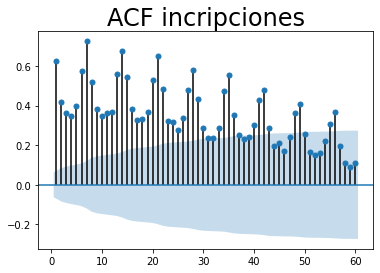

In [ ]:
sgt.plot_acf(df.inscripciones, lags = 60, zero = False)
plt.title("ACF incripciones", size = 24)
plt.show()

**Autocorrelación:** Existe correlación positiva entre la autocorrelación con periodos de hasta mas de 50 días. Asimismo se están considerando efectos directos e indirectos de los períodos pasados. 


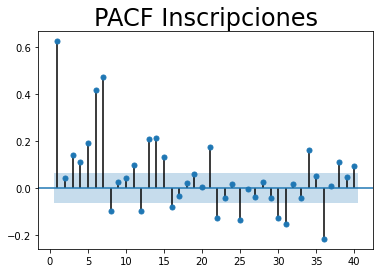

In [ ]:
sgt.plot_pacf(df.inscripciones, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Inscripciones", size = 24)
plt.show()

### Modelo AR(1)

In [7]:
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns
sns.set()

# Modelo de orden 1 sin considerar residuos
model_ar = ARMA(dfAR.inscripciones, order=(1,0))
results_ar = model_ar.fit()
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          inscripciones   No. Observations:                  968
Model:                     ARMA(1, 0)   Log Likelihood               -4674.618
Method:                       css-mle   S.D. of innovations             30.264
Date:                Thu, 01 Oct 2020   AIC                           9355.237
Time:                        15:04:12   BIC                           9369.862
Sample:                    01-02-2018   HQIC                          9360.804
                         - 09-03-2020                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.1455      2.585     15.530      0.000      35.079      45.212
ar.L1.inscripciones     0.6244      0.025     24.889      0.000       0.575       0.674
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6016           +0.0000j            1.6016            0.0000
-----------------------------------------------------------------------------
"""

*   const -> Indica el coeficiente de la parte constante de la ecuación ($C$)
*   ar.L1 -> indica el coeficiente de la serie con retraso 1 (-1 > $\varphi$ > 1)

$$ X_{t} = \varphi_{1}X_{t-1} + \varepsilon_{t} + C$$

Hipotesis Nula: Coeficiente es significativamente igual a cero

Z (que es el estadistico utilizado para medir la significacion de las estimaciones)

Como el P valor es muy cercano a 0 (< 0.05) se rechaza la hipotisis nula, con lo cual se determina que el coeficiente es significativo.

Otra manera de ver el nivel de significacion es revisar los intervalo de confianza, si no contiene al 0 decimos que el coeficiente es distinto de 0, por lo tanto es significativo. Para este caso ambos serían significativos y distintos de 0.


### Modelos con retraso AR(n)

In [8]:
model_ar_2 = ARMA(dfAR.inscripciones, order=(2,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          inscripciones   No. Observations:                  968
Model:                     ARMA(2, 0)   Log Likelihood               -4673.685
Method:                       css-mle   S.D. of innovations             30.235
Date:                Thu, 01 Oct 2020   AIC                           9355.370
Time:                        15:04:20   BIC                           9374.871
Sample:                    01-02-2018   HQIC                          9362.793
                         - 09-03-2020                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.1322      2.700     14.862      0.000      34.840      45.425
ar.L1.inscripciones     0.5970      0.032     18.602      0.000       0.534       0.660
ar.L2.inscripciones     0.0439      0.032      1.367      0.172      -0.019       0.107
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5080           +0.0000j            1.5080            0.0000
AR.2          -15.1117           +0.0000j           15.1117            0.5000
-----------------------------------------------------------------------------
"""

En es caso el segundo coeficiente no es significativamente distinto de 0, por dos razones. Primero, el P valor (0.172) es mayor a 0.05. Segundo, el intervalo de confianza (-0.019 - 0.107) incluye al 0. Por lo tanto no se rechaza la hipotesis nula y se supone que el coeficiente es igual a 0. 

In [9]:
model_ar_3 = ARMA(dfAR.inscripciones, order=(3,0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          inscripciones   No. Observations:                  968
Model:                     ARMA(3, 0)   Log Likelihood               -4663.951
Method:                       css-mle   S.D. of innovations             29.931
Date:                Thu, 01 Oct 2020   AIC                           9337.902
Time:                        15:04:26   BIC                           9362.278
Sample:                    01-02-2018   HQIC                          9347.181
                         - 09-03-2020                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.1149      3.109     12.902      0.000      34.021      46.209
ar.L1.inscripciones     0.5906      0.032     18.572      0.000       0.528       0.653
ar.L2.inscripciones    -0.0407      0.037     -1.097      0.273      -0.113       0.032
ar.L3.inscripciones     0.1416      0.032      4.435      0.000       0.079       0.204
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2915           -0.0000j            1.2915           -0.0000
AR.2           -0.5022           -2.2841j            2.3387           -0.2844
AR.3           -0.5022           +2.2841j            2.3387            0.2844
-----------------------------------------------------------------------------
"""

En es caso el segundo coeficiente no es significativamente distinto de 0, por dos razones. Primero, el P valor (0.273) es mayor a 0.05. Segundo, el intervalo de confianza (-0.113 - 0.032) incluye al 0. Por lo tanto no se rechaza la hipotesis nula y se supone que el coeficiente es igual a 0. 


In [10]:
model_ar_4 = ARMA(dfAR.inscripciones, order=[4,0])
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          inscripciones   No. Observations:                  968
Model:                     ARMA(4, 0)   Log Likelihood               -4658.170
Method:                       css-mle   S.D. of innovations             29.752
Date:                Thu, 01 Oct 2020   AIC                           9328.340
Time:                        15:04:33   BIC                           9357.592
Sample:                    01-02-2018   HQIC                          9339.476
                         - 09-03-2020                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.0922      3.465     11.572      0.000      33.302      46.883
ar.L1.inscripciones     0.5753      0.032     18.015      0.000       0.513       0.638
ar.L2.inscripciones    -0.0363      0.037     -0.984      0.325      -0.108       0.036
ar.L3.inscripciones     0.0769      0.037      2.082      0.038       0.005       0.149
ar.L4.inscripciones     0.1093      0.032      3.411      0.001       0.046       0.172
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2015           -0.0000j            1.2015           -0.0000
AR.2            0.2507           -1.7611j            1.7789           -0.2275
AR.3            0.2507           +1.7611j            1.7789            0.2275
AR.4           -2.4070           -0.0000j            2.4070           -0.5000
-----------------------------------------------------------------------------
"""

En es caso el segundo coeficiente no es significativamente distinto de 0, por dos razones. Primero, el P valor (0.325) es mayor a 0.05. Segundo, el intervalo de confianza (-0.108 - 0.036) incluye al 0. Por lo tanto no se rechaza la hipotesis nula y se supone que el coeficiente es igual a 0. 

### Contraste de modelos

Contraste de razón de log verosimilitudes (LLT)

Es necesario considerar que antes de comparar dos modelos, el nivel de significación del último retraso sea diferente de 0, para poder tener claro el grado de libertad real de cada modelo que se está comparando

In [11]:
# recibe como parametro los dos modelos a comparar y el grado de libertad
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

Comparando el modelo 2 con el modelo 3

In [12]:
LLR_test(results_ar_2, results_ar_3)

0.0

Hipotesis nula: ambos modelos son significativamente similares.

El resultado es el P valor del contraste de hipotesis, al ser menor al nivel de significacion 0.05 se rechaza la hipotesis nula. Por lo tanto se elegiría el modelo 3 por ser significativamente diferentes

Comparando modelo 3 con modelo 4

In [13]:
LLR_test(results_ar_3, results_ar_4)

0.001

Al ser menor al nivel de significacion 0.05 se rechaza la hipotesis nula. Por lo tanto se elegiría el modelo 4 por ser significativamente diferentes

In [14]:
model_ar_5 = ARMA(dfAR.inscripciones, order=(5,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_4, results_ar_5)))

                              ARMA Model Results                              
Dep. Variable:          inscripciones   No. Observations:                  968
Model:                     ARMA(5, 0)   Log Likelihood               -4640.867
Method:                       css-mle   S.D. of innovations             29.222
Date:                Thu, 01 Oct 2020   AIC                           9295.735
Time:                        15:21:31   BIC                           9329.861
Sample:                    01-02-2018   HQIC                          9308.726
                         - 09-03-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.1685      4.203      9.558      0.000      31.931      48.406
ar.L1.inscripciones     0.5541      0.032     17.555      0.000       0.492       0.616
ar.L2.inscripcio

In [15]:
model_ar_6 = ARMA(dfAR.inscripciones, order=(6,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_5, results_ar_6)))

                              ARMA Model Results                              
Dep. Variable:          inscripciones   No. Observations:                  968
Model:                     ARMA(6, 0)   Log Likelihood               -4553.161
Method:                       css-mle   S.D. of innovations             26.675
Date:                Thu, 01 Oct 2020   AIC                           9122.322
Time:                        15:22:14   BIC                           9161.324
Sample:                    01-02-2018   HQIC                          9137.169
                         - 09-03-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  40.2533      6.481      6.211      0.000      27.550      52.956
ar.L1.inscripciones     0.4782      0.029     16.316      0.000       0.421       0.536
ar.L2.inscripcio

In [16]:
model_ar_7 = ARMA(dfAR.inscripciones, order=(7,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_6, results_ar_7)))

                              ARMA Model Results                              
Dep. Variable:          inscripciones   No. Observations:                  968
Model:                     ARMA(7, 0)   Log Likelihood               -4440.853
Method:                       css-mle   S.D. of innovations             23.732
Date:                Thu, 01 Oct 2020   AIC                           8899.707
Time:                        15:36:11   BIC                           8943.584
Sample:                    01-02-2018   HQIC                          8916.409
                         - 09-03-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  41.4191     11.188      3.702      0.000      19.490      63.348
ar.L1.inscripciones     0.2881      0.029     10.054      0.000       0.232       0.344
ar.L2.inscripcio